# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

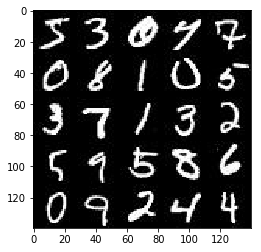

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

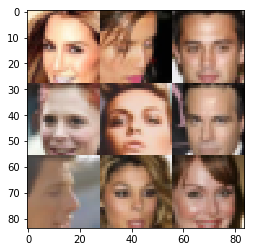

In [3]:
show_n_images = 9

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')

pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


C:\Users\MKenneth\Miniconda3\envs\tensorfloww\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, image_width,image_height,image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        relu1 = tf.maximum(0.15 * x1, x1)
        # 14x14x64
        drop_out1 = tf.nn.dropout(relu1, 0.8)
        x2 = tf.layers.conv2d(drop_out1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.15 * bn2, bn2)
        # 7x7x128
        drop_out2 = tf.nn.dropout(relu2, 0.8)
        x3 = tf.layers.conv2d(drop_out2, 128, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(0.15 * bn3, bn3)
        # 7x7x256
        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
    #return None, None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*1024,kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        #print(z)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 1024))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.15 * x1, x1)
        # 4x4x512 now
        #print(x1)
        x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.15 * x2, x2)
        x2 = tf.nn.dropout(x2, 0.8)
        # 8x8x256 now
        x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.15 * x3, x3)
        x3 = tf.nn.dropout(x3, 0.8)
        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(0.15 * x4, x4)
        x4 = tf.nn.dropout(x4, 0.8)
        # 16x16x128 now
        #x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides=2, padding='same')
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')
        # 32x32x3 now
        out = tf.tanh(logits)
        
        return out
    #return None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-0.1)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    #return None, None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
    #return None, None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #saver = tf.train.Saver()
    inputs_real, inputs_z, learning_r = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    d_loss, g_loss = model_loss(inputs_real,inputs_z,data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_r, beta1)
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    print_every = 5 #Print every 5 batches
    show_every = 100
    samples, losses = [], []
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #print(batch_images)
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images*2, inputs_z: batch_z,learning_r: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images*2,learning_r: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images*2,learning_r: learning_rate})
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images*2})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)
       
    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9271... Generator Loss: 1.1613
Epoch 1/2... Discriminator Loss: 0.4100... Generator Loss: 7.8283
Epoch 1/2... Discriminator Loss: 0.5454... Generator Loss: 2.0729
Epoch 1/2... Discriminator Loss: 3.9386... Generator Loss: 0.0640
Epoch 1/2... Discriminator Loss: 2.0789... Generator Loss: 3.1187
Epoch 1/2... Discriminator Loss: 1.7107... Generator Loss: 0.4751
Epoch 1/2... Discriminator Loss: 3.9562... Generator Loss: 0.1542
Epoch 1/2... Discriminator Loss: 2.1161... Generator Loss: 0.5562
Epoch 1/2... Discriminator Loss: 2.5071... Generator Loss: 0.7250
Epoch 1/2... Discriminator Loss: 2.9394... Generator Loss: 0.2019
Epoch 1/2... Discriminator Loss: 2.3593... Generator Loss: 0.2945
Epoch 1/2... Discriminator Loss: 2.7219... Generator Loss: 0.5772
Epoch 1/2... Discriminator Loss: 2.4007... Generator Loss: 0.1665
Epoch 1/2... Discriminator Loss: 2.8785... Generator Loss: 0.0860
Epoch 1/2... Discriminator Loss: 3.1126... Generator Loss: 0.1249
Epoch 1/2.

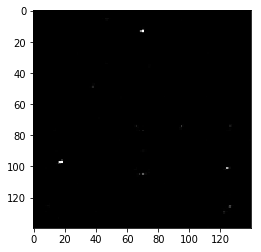

Epoch 1/2... Discriminator Loss: 2.0107... Generator Loss: 0.2824
Epoch 1/2... Discriminator Loss: 2.0162... Generator Loss: 0.3207
Epoch 1/2... Discriminator Loss: 2.0170... Generator Loss: 0.3421
Epoch 1/2... Discriminator Loss: 2.1564... Generator Loss: 0.2125
Epoch 1/2... Discriminator Loss: 2.2343... Generator Loss: 0.2281
Epoch 1/2... Discriminator Loss: 2.1878... Generator Loss: 0.3074
Epoch 1/2... Discriminator Loss: 2.4135... Generator Loss: 0.2744
Epoch 1/2... Discriminator Loss: 2.0094... Generator Loss: 0.3919
Epoch 1/2... Discriminator Loss: 2.7538... Generator Loss: 0.3038
Epoch 1/2... Discriminator Loss: 2.2966... Generator Loss: 0.5364
Epoch 1/2... Discriminator Loss: 2.5503... Generator Loss: 0.1615
Epoch 1/2... Discriminator Loss: 2.0223... Generator Loss: 0.6029
Epoch 1/2... Discriminator Loss: 2.4094... Generator Loss: 0.3655
Epoch 1/2... Discriminator Loss: 2.4405... Generator Loss: 0.1727
Epoch 1/2... Discriminator Loss: 1.8986... Generator Loss: 0.4959
Epoch 1/2.

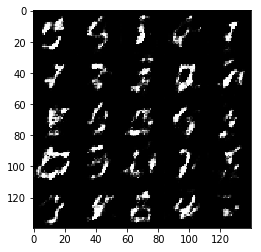

Epoch 1/2... Discriminator Loss: 1.9704... Generator Loss: 0.5560
Epoch 1/2... Discriminator Loss: 1.7089... Generator Loss: 0.8295
Epoch 1/2... Discriminator Loss: 1.6071... Generator Loss: 0.5180
Epoch 1/2... Discriminator Loss: 1.6643... Generator Loss: 0.5715
Epoch 1/2... Discriminator Loss: 1.8906... Generator Loss: 0.2942
Epoch 1/2... Discriminator Loss: 1.8584... Generator Loss: 0.4155
Epoch 1/2... Discriminator Loss: 2.1664... Generator Loss: 0.1783
Epoch 1/2... Discriminator Loss: 2.3386... Generator Loss: 0.2152
Epoch 1/2... Discriminator Loss: 1.7834... Generator Loss: 0.5379
Epoch 1/2... Discriminator Loss: 1.9134... Generator Loss: 0.4116
Epoch 1/2... Discriminator Loss: 2.1950... Generator Loss: 0.3148
Epoch 1/2... Discriminator Loss: 1.9058... Generator Loss: 0.3407
Epoch 1/2... Discriminator Loss: 2.1459... Generator Loss: 0.2473
Epoch 1/2... Discriminator Loss: 2.0402... Generator Loss: 0.3249
Epoch 1/2... Discriminator Loss: 2.2900... Generator Loss: 0.7093
Epoch 1/2.

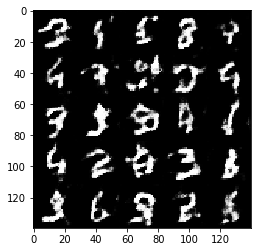

Epoch 1/2... Discriminator Loss: 2.7200... Generator Loss: 0.1483
Epoch 1/2... Discriminator Loss: 1.9781... Generator Loss: 0.3586
Epoch 1/2... Discriminator Loss: 2.0287... Generator Loss: 0.7822
Epoch 1/2... Discriminator Loss: 1.7844... Generator Loss: 0.4658
Epoch 1/2... Discriminator Loss: 2.0973... Generator Loss: 0.2937
Epoch 1/2... Discriminator Loss: 2.1208... Generator Loss: 0.2811
Epoch 1/2... Discriminator Loss: 1.8305... Generator Loss: 0.4196
Epoch 1/2... Discriminator Loss: 1.8183... Generator Loss: 0.3718
Epoch 1/2... Discriminator Loss: 1.9388... Generator Loss: 0.4311
Epoch 1/2... Discriminator Loss: 2.2495... Generator Loss: 0.1813
Epoch 1/2... Discriminator Loss: 1.9086... Generator Loss: 0.2492
Epoch 1/2... Discriminator Loss: 1.9167... Generator Loss: 0.5860
Epoch 1/2... Discriminator Loss: 2.0010... Generator Loss: 0.3019
Epoch 1/2... Discriminator Loss: 1.8125... Generator Loss: 0.7874
Epoch 1/2... Discriminator Loss: 2.1583... Generator Loss: 0.2296
Epoch 1/2.

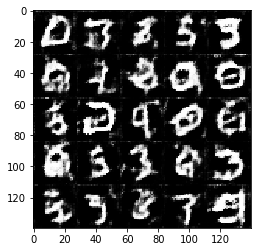

Epoch 1/2... Discriminator Loss: 2.0713... Generator Loss: 0.4397
Epoch 1/2... Discriminator Loss: 2.0480... Generator Loss: 0.4715
Epoch 1/2... Discriminator Loss: 2.1977... Generator Loss: 0.2050
Epoch 1/2... Discriminator Loss: 1.6581... Generator Loss: 0.6772
Epoch 1/2... Discriminator Loss: 2.1175... Generator Loss: 0.3181
Epoch 1/2... Discriminator Loss: 1.8857... Generator Loss: 0.4402
Epoch 1/2... Discriminator Loss: 1.9729... Generator Loss: 0.8547
Epoch 1/2... Discriminator Loss: 2.0791... Generator Loss: 0.2590
Epoch 1/2... Discriminator Loss: 1.9508... Generator Loss: 0.3520
Epoch 1/2... Discriminator Loss: 1.4789... Generator Loss: 0.6311
Epoch 1/2... Discriminator Loss: 2.2164... Generator Loss: 0.2195
Epoch 1/2... Discriminator Loss: 2.0324... Generator Loss: 0.2435
Epoch 1/2... Discriminator Loss: 1.7346... Generator Loss: 0.5810
Epoch 1/2... Discriminator Loss: 1.7647... Generator Loss: 0.4941
Epoch 1/2... Discriminator Loss: 2.0880... Generator Loss: 0.2946
Epoch 1/2.

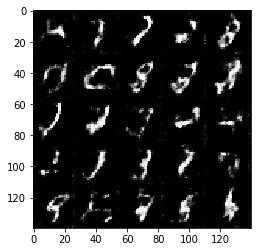

Epoch 1/2... Discriminator Loss: 1.8239... Generator Loss: 0.4282
Epoch 1/2... Discriminator Loss: 1.8960... Generator Loss: 0.4765
Epoch 1/2... Discriminator Loss: 1.5102... Generator Loss: 0.6862
Epoch 1/2... Discriminator Loss: 1.7929... Generator Loss: 1.1713
Epoch 1/2... Discriminator Loss: 1.8509... Generator Loss: 0.3809
Epoch 1/2... Discriminator Loss: 1.7938... Generator Loss: 0.8397
Epoch 1/2... Discriminator Loss: 1.8517... Generator Loss: 0.3529
Epoch 1/2... Discriminator Loss: 1.5887... Generator Loss: 0.7463
Epoch 1/2... Discriminator Loss: 1.9902... Generator Loss: 0.2793
Epoch 1/2... Discriminator Loss: 1.7895... Generator Loss: 0.4998
Epoch 1/2... Discriminator Loss: 1.7881... Generator Loss: 0.4108
Epoch 1/2... Discriminator Loss: 1.9384... Generator Loss: 0.3067
Epoch 1/2... Discriminator Loss: 1.9252... Generator Loss: 0.6171
Epoch 1/2... Discriminator Loss: 1.7591... Generator Loss: 0.9183
Epoch 1/2... Discriminator Loss: 2.0560... Generator Loss: 0.2678
Epoch 1/2.

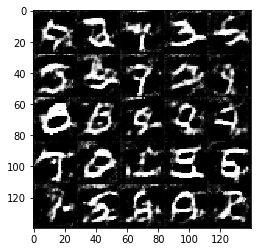

Epoch 1/2... Discriminator Loss: 1.7323... Generator Loss: 0.5971
Epoch 1/2... Discriminator Loss: 1.8085... Generator Loss: 1.2002
Epoch 1/2... Discriminator Loss: 1.4947... Generator Loss: 0.6653
Epoch 1/2... Discriminator Loss: 1.6892... Generator Loss: 0.5636
Epoch 1/2... Discriminator Loss: 1.7291... Generator Loss: 0.5047
Epoch 1/2... Discriminator Loss: 1.5090... Generator Loss: 0.6384
Epoch 1/2... Discriminator Loss: 1.8343... Generator Loss: 0.7404
Epoch 1/2... Discriminator Loss: 1.6639... Generator Loss: 0.4359
Epoch 1/2... Discriminator Loss: 1.7894... Generator Loss: 0.3707
Epoch 1/2... Discriminator Loss: 2.0705... Generator Loss: 0.2740
Epoch 1/2... Discriminator Loss: 1.9646... Generator Loss: 0.3889
Epoch 1/2... Discriminator Loss: 1.6066... Generator Loss: 0.4587
Epoch 1/2... Discriminator Loss: 1.8768... Generator Loss: 0.2839
Epoch 1/2... Discriminator Loss: 1.6727... Generator Loss: 0.7112
Epoch 1/2... Discriminator Loss: 1.6677... Generator Loss: 0.7374
Epoch 1/2.

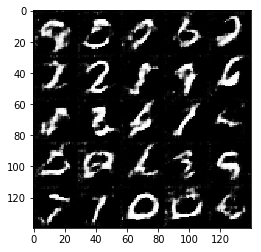

Epoch 1/2... Discriminator Loss: 2.0629... Generator Loss: 0.3102
Epoch 1/2... Discriminator Loss: 2.4271... Generator Loss: 0.1480
Epoch 1/2... Discriminator Loss: 1.9950... Generator Loss: 0.5768
Epoch 1/2... Discriminator Loss: 1.8819... Generator Loss: 0.3005
Epoch 1/2... Discriminator Loss: 1.7741... Generator Loss: 0.3175
Epoch 1/2... Discriminator Loss: 1.9655... Generator Loss: 0.4563
Epoch 1/2... Discriminator Loss: 2.1035... Generator Loss: 0.2103
Epoch 1/2... Discriminator Loss: 1.7804... Generator Loss: 0.3740
Epoch 1/2... Discriminator Loss: 1.7071... Generator Loss: 0.3676
Epoch 1/2... Discriminator Loss: 1.7751... Generator Loss: 0.6381
Epoch 1/2... Discriminator Loss: 1.9028... Generator Loss: 0.5862
Epoch 1/2... Discriminator Loss: 1.5467... Generator Loss: 0.4795
Epoch 1/2... Discriminator Loss: 1.8525... Generator Loss: 0.2827
Epoch 1/2... Discriminator Loss: 1.7478... Generator Loss: 0.5031
Epoch 1/2... Discriminator Loss: 1.7812... Generator Loss: 0.2984
Epoch 1/2.

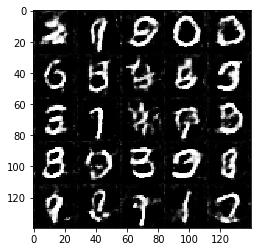

Epoch 1/2... Discriminator Loss: 1.8407... Generator Loss: 0.3411
Epoch 1/2... Discriminator Loss: 1.7520... Generator Loss: 0.4440
Epoch 1/2... Discriminator Loss: 1.8130... Generator Loss: 0.5032
Epoch 1/2... Discriminator Loss: 2.1819... Generator Loss: 0.2444
Epoch 1/2... Discriminator Loss: 1.5388... Generator Loss: 1.0346
Epoch 1/2... Discriminator Loss: 1.6905... Generator Loss: 0.9117
Epoch 1/2... Discriminator Loss: 1.9101... Generator Loss: 0.2743
Epoch 1/2... Discriminator Loss: 1.7137... Generator Loss: 1.1630
Epoch 1/2... Discriminator Loss: 1.9231... Generator Loss: 0.3264
Epoch 1/2... Discriminator Loss: 1.6126... Generator Loss: 0.5894
Epoch 1/2... Discriminator Loss: 1.7223... Generator Loss: 0.3476
Epoch 1/2... Discriminator Loss: 1.7307... Generator Loss: 0.4769
Epoch 1/2... Discriminator Loss: 1.9078... Generator Loss: 0.3040
Epoch 1/2... Discriminator Loss: 1.6508... Generator Loss: 0.6697
Epoch 1/2... Discriminator Loss: 1.8663... Generator Loss: 0.2741
Epoch 1/2.

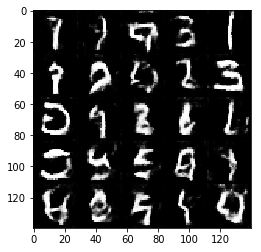

Epoch 1/2... Discriminator Loss: 1.5684... Generator Loss: 0.9974
Epoch 1/2... Discriminator Loss: 1.8084... Generator Loss: 0.3075
Epoch 1/2... Discriminator Loss: 2.0445... Generator Loss: 0.2913
Epoch 1/2... Discriminator Loss: 1.6159... Generator Loss: 0.7971
Epoch 1/2... Discriminator Loss: 2.0615... Generator Loss: 0.2071
Epoch 1/2... Discriminator Loss: 1.8235... Generator Loss: 0.4177
Epoch 1/2... Discriminator Loss: 1.8207... Generator Loss: 0.3518
Epoch 1/2... Discriminator Loss: 1.7980... Generator Loss: 0.5182
Epoch 1/2... Discriminator Loss: 1.6771... Generator Loss: 0.4220
Epoch 1/2... Discriminator Loss: 1.8143... Generator Loss: 0.7699
Epoch 1/2... Discriminator Loss: 1.6822... Generator Loss: 0.3919
Epoch 1/2... Discriminator Loss: 1.6917... Generator Loss: 0.8725
Epoch 1/2... Discriminator Loss: 1.6939... Generator Loss: 1.1994
Epoch 1/2... Discriminator Loss: 1.8971... Generator Loss: 0.2982
Epoch 1/2... Discriminator Loss: 1.6478... Generator Loss: 0.3256
Epoch 1/2.

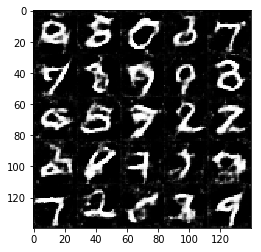

Epoch 1/2... Discriminator Loss: 1.6569... Generator Loss: 0.4634
Epoch 1/2... Discriminator Loss: 2.0564... Generator Loss: 0.5673
Epoch 1/2... Discriminator Loss: 1.5456... Generator Loss: 0.5350
Epoch 1/2... Discriminator Loss: 1.3243... Generator Loss: 0.5829
Epoch 1/2... Discriminator Loss: 1.9742... Generator Loss: 1.2121
Epoch 1/2... Discriminator Loss: 1.7555... Generator Loss: 0.6267
Epoch 1/2... Discriminator Loss: 1.6906... Generator Loss: 0.3554
Epoch 1/2... Discriminator Loss: 2.1465... Generator Loss: 0.2272
Epoch 1/2... Discriminator Loss: 1.7974... Generator Loss: 0.3026
Epoch 1/2... Discriminator Loss: 1.6126... Generator Loss: 0.6264
Epoch 1/2... Discriminator Loss: 1.6092... Generator Loss: 0.3842
Epoch 1/2... Discriminator Loss: 1.6557... Generator Loss: 0.7098
Epoch 1/2... Discriminator Loss: 1.8930... Generator Loss: 0.3429
Epoch 1/2... Discriminator Loss: 1.9917... Generator Loss: 0.3093
Epoch 1/2... Discriminator Loss: 1.8346... Generator Loss: 0.2954
Epoch 1/2.

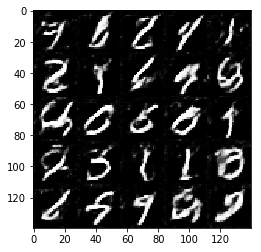

Epoch 1/2... Discriminator Loss: 1.7185... Generator Loss: 0.5795
Epoch 1/2... Discriminator Loss: 1.7806... Generator Loss: 0.9654
Epoch 1/2... Discriminator Loss: 1.4586... Generator Loss: 0.6493
Epoch 1/2... Discriminator Loss: 1.6201... Generator Loss: 0.4653
Epoch 1/2... Discriminator Loss: 1.3696... Generator Loss: 0.6825
Epoch 1/2... Discriminator Loss: 1.9105... Generator Loss: 0.4399
Epoch 1/2... Discriminator Loss: 1.7090... Generator Loss: 0.6742
Epoch 1/2... Discriminator Loss: 1.7341... Generator Loss: 1.2067
Epoch 1/2... Discriminator Loss: 1.7101... Generator Loss: 0.9660
Epoch 1/2... Discriminator Loss: 1.5645... Generator Loss: 0.6702
Epoch 1/2... Discriminator Loss: 1.6386... Generator Loss: 0.7725
Epoch 1/2... Discriminator Loss: 1.7867... Generator Loss: 0.3775
Epoch 1/2... Discriminator Loss: 1.8795... Generator Loss: 0.2982
Epoch 1/2... Discriminator Loss: 1.5006... Generator Loss: 0.6925
Epoch 1/2... Discriminator Loss: 1.8225... Generator Loss: 0.3887
Epoch 1/2.

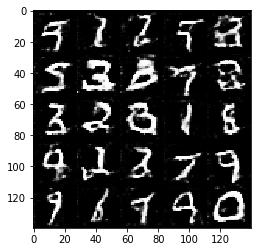

Epoch 1/2... Discriminator Loss: 1.6289... Generator Loss: 0.3444
Epoch 1/2... Discriminator Loss: 1.7008... Generator Loss: 0.6506
Epoch 1/2... Discriminator Loss: 1.8666... Generator Loss: 0.2614
Epoch 1/2... Discriminator Loss: 1.6475... Generator Loss: 0.9598
Epoch 1/2... Discriminator Loss: 1.7283... Generator Loss: 0.9817
Epoch 1/2... Discriminator Loss: 1.8291... Generator Loss: 0.4298
Epoch 1/2... Discriminator Loss: 1.7445... Generator Loss: 0.6875
Epoch 1/2... Discriminator Loss: 2.2295... Generator Loss: 0.2087
Epoch 1/2... Discriminator Loss: 1.7431... Generator Loss: 0.3933
Epoch 1/2... Discriminator Loss: 1.6870... Generator Loss: 0.9105
Epoch 1/2... Discriminator Loss: 1.8620... Generator Loss: 0.3625
Epoch 1/2... Discriminator Loss: 1.6712... Generator Loss: 0.4296
Epoch 1/2... Discriminator Loss: 1.8397... Generator Loss: 0.3907
Epoch 1/2... Discriminator Loss: 1.3447... Generator Loss: 0.7324
Epoch 1/2... Discriminator Loss: 1.8241... Generator Loss: 0.4718
Epoch 1/2.

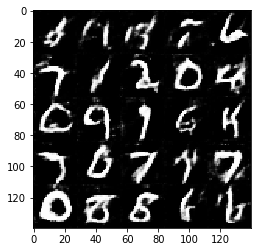

Epoch 1/2... Discriminator Loss: 1.6469... Generator Loss: 0.4543
Epoch 1/2... Discriminator Loss: 1.5500... Generator Loss: 0.5783
Epoch 1/2... Discriminator Loss: 1.4798... Generator Loss: 0.6724
Epoch 1/2... Discriminator Loss: 1.7791... Generator Loss: 0.4202
Epoch 1/2... Discriminator Loss: 1.6201... Generator Loss: 0.6769
Epoch 1/2... Discriminator Loss: 1.5723... Generator Loss: 0.9247
Epoch 1/2... Discriminator Loss: 1.9010... Generator Loss: 0.3044
Epoch 1/2... Discriminator Loss: 1.5769... Generator Loss: 0.6566
Epoch 1/2... Discriminator Loss: 1.7470... Generator Loss: 0.7075
Epoch 1/2... Discriminator Loss: 1.7751... Generator Loss: 0.3081
Epoch 1/2... Discriminator Loss: 1.6420... Generator Loss: 0.4969
Epoch 1/2... Discriminator Loss: 1.8835... Generator Loss: 0.4457
Epoch 1/2... Discriminator Loss: 1.7137... Generator Loss: 0.4768
Epoch 1/2... Discriminator Loss: 1.4561... Generator Loss: 0.5432
Epoch 1/2... Discriminator Loss: 1.8253... Generator Loss: 0.3353
Epoch 1/2.

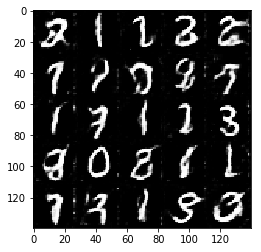

Epoch 1/2... Discriminator Loss: 1.6268... Generator Loss: 0.5318
Epoch 1/2... Discriminator Loss: 1.7869... Generator Loss: 0.4041
Epoch 1/2... Discriminator Loss: 1.9078... Generator Loss: 0.3632
Epoch 1/2... Discriminator Loss: 1.7126... Generator Loss: 0.3903
Epoch 1/2... Discriminator Loss: 1.6149... Generator Loss: 0.4408
Epoch 1/2... Discriminator Loss: 1.4783... Generator Loss: 1.0999
Epoch 1/2... Discriminator Loss: 1.6630... Generator Loss: 0.6318
Epoch 1/2... Discriminator Loss: 1.7155... Generator Loss: 0.3976
Epoch 1/2... Discriminator Loss: 1.5103... Generator Loss: 0.7949
Epoch 1/2... Discriminator Loss: 2.0012... Generator Loss: 0.2693
Epoch 1/2... Discriminator Loss: 1.8409... Generator Loss: 0.3597
Epoch 1/2... Discriminator Loss: 1.8175... Generator Loss: 0.3402
Epoch 1/2... Discriminator Loss: 1.4030... Generator Loss: 0.9668
Epoch 1/2... Discriminator Loss: 1.6013... Generator Loss: 0.9626
Epoch 1/2... Discriminator Loss: 1.7727... Generator Loss: 1.0112
Epoch 1/2.

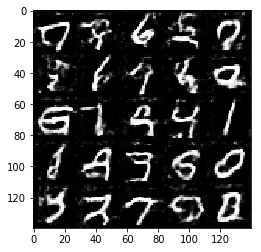

Epoch 1/2... Discriminator Loss: 1.4702... Generator Loss: 0.6765
Epoch 1/2... Discriminator Loss: 1.5469... Generator Loss: 0.7354
Epoch 1/2... Discriminator Loss: 1.6560... Generator Loss: 0.4637
Epoch 1/2... Discriminator Loss: 1.5527... Generator Loss: 0.5366
Epoch 1/2... Discriminator Loss: 1.5629... Generator Loss: 0.4653
Epoch 1/2... Discriminator Loss: 1.6149... Generator Loss: 0.7591
Epoch 1/2... Discriminator Loss: 1.8952... Generator Loss: 0.2779
Epoch 1/2... Discriminator Loss: 1.4670... Generator Loss: 1.1636
Epoch 1/2... Discriminator Loss: 1.6283... Generator Loss: 0.4923
Epoch 1/2... Discriminator Loss: 1.5945... Generator Loss: 0.5074
Epoch 1/2... Discriminator Loss: 1.5541... Generator Loss: 0.8162
Epoch 1/2... Discriminator Loss: 1.8304... Generator Loss: 0.5918
Epoch 1/2... Discriminator Loss: 1.7979... Generator Loss: 0.3380
Epoch 1/2... Discriminator Loss: 1.6730... Generator Loss: 0.5423
Epoch 1/2... Discriminator Loss: 1.7004... Generator Loss: 0.6866
Epoch 1/2.

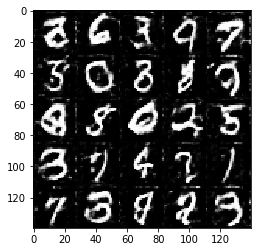

Epoch 1/2... Discriminator Loss: 1.5411... Generator Loss: 0.4788
Epoch 1/2... Discriminator Loss: 1.7574... Generator Loss: 0.4450
Epoch 1/2... Discriminator Loss: 1.7743... Generator Loss: 0.3517
Epoch 1/2... Discriminator Loss: 1.5487... Generator Loss: 0.4636
Epoch 1/2... Discriminator Loss: 2.2418... Generator Loss: 0.1723
Epoch 1/2... Discriminator Loss: 1.7404... Generator Loss: 0.4750
Epoch 1/2... Discriminator Loss: 1.6842... Generator Loss: 0.7617
Epoch 1/2... Discriminator Loss: 1.3667... Generator Loss: 0.8849
Epoch 1/2... Discriminator Loss: 1.9136... Generator Loss: 0.2297
Epoch 1/2... Discriminator Loss: 1.4874... Generator Loss: 0.4630
Epoch 1/2... Discriminator Loss: 1.5625... Generator Loss: 1.0086
Epoch 1/2... Discriminator Loss: 1.5017... Generator Loss: 1.0068
Epoch 1/2... Discriminator Loss: 1.5820... Generator Loss: 0.5152
Epoch 1/2... Discriminator Loss: 1.7485... Generator Loss: 0.6619
Epoch 1/2... Discriminator Loss: 1.5326... Generator Loss: 0.4925
Epoch 1/2.

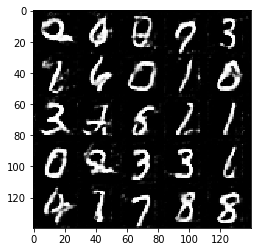

Epoch 1/2... Discriminator Loss: 1.5993... Generator Loss: 1.0420
Epoch 1/2... Discriminator Loss: 1.3335... Generator Loss: 0.8441
Epoch 1/2... Discriminator Loss: 2.3792... Generator Loss: 0.1771
Epoch 1/2... Discriminator Loss: 1.6061... Generator Loss: 0.8086
Epoch 1/2... Discriminator Loss: 1.5959... Generator Loss: 0.4272
Epoch 1/2... Discriminator Loss: 1.8842... Generator Loss: 0.4543
Epoch 1/2... Discriminator Loss: 1.2393... Generator Loss: 1.1041
Epoch 1/2... Discriminator Loss: 1.4503... Generator Loss: 0.5582
Epoch 1/2... Discriminator Loss: 1.5939... Generator Loss: 0.3973
Epoch 1/2... Discriminator Loss: 1.6278... Generator Loss: 0.4352
Epoch 1/2... Discriminator Loss: 1.4738... Generator Loss: 0.6301
Epoch 1/2... Discriminator Loss: 1.8029... Generator Loss: 0.3370
Epoch 1/2... Discriminator Loss: 1.7506... Generator Loss: 0.3999
Epoch 1/2... Discriminator Loss: 2.0557... Generator Loss: 0.2211
Epoch 1/2... Discriminator Loss: 1.3347... Generator Loss: 0.8070
Epoch 1/2.

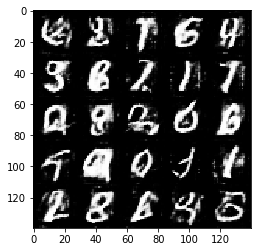

Epoch 1/2... Discriminator Loss: 1.7549... Generator Loss: 0.7695
Epoch 1/2... Discriminator Loss: 1.5026... Generator Loss: 0.5584
Epoch 1/2... Discriminator Loss: 1.7152... Generator Loss: 0.4786
Epoch 1/2... Discriminator Loss: 1.8408... Generator Loss: 0.3522
Epoch 1/2... Discriminator Loss: 1.7081... Generator Loss: 0.4922
Epoch 1/2... Discriminator Loss: 1.7533... Generator Loss: 0.4632
Epoch 1/2... Discriminator Loss: 1.7700... Generator Loss: 0.8273
Epoch 1/2... Discriminator Loss: 1.3394... Generator Loss: 0.8633
Epoch 1/2... Discriminator Loss: 1.5905... Generator Loss: 0.8697
Epoch 1/2... Discriminator Loss: 1.8504... Generator Loss: 0.3207
Epoch 1/2... Discriminator Loss: 1.2620... Generator Loss: 0.6700
Epoch 1/2... Discriminator Loss: 1.9488... Generator Loss: 0.3154
Epoch 1/2... Discriminator Loss: 1.9647... Generator Loss: 0.2544
Epoch 1/2... Discriminator Loss: 1.3970... Generator Loss: 0.5376
Epoch 1/2... Discriminator Loss: 1.3152... Generator Loss: 0.7831
Epoch 2/2.

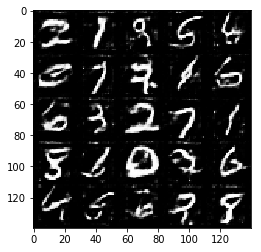

Epoch 2/2... Discriminator Loss: 1.7414... Generator Loss: 0.4050
Epoch 2/2... Discriminator Loss: 1.6385... Generator Loss: 0.4135
Epoch 2/2... Discriminator Loss: 1.5880... Generator Loss: 0.8727
Epoch 2/2... Discriminator Loss: 1.4701... Generator Loss: 0.8940
Epoch 2/2... Discriminator Loss: 1.4772... Generator Loss: 0.6109
Epoch 2/2... Discriminator Loss: 1.6902... Generator Loss: 0.9340
Epoch 2/2... Discriminator Loss: 1.4609... Generator Loss: 0.9036
Epoch 2/2... Discriminator Loss: 1.6890... Generator Loss: 0.9856
Epoch 2/2... Discriminator Loss: 2.1854... Generator Loss: 0.2533
Epoch 2/2... Discriminator Loss: 1.4820... Generator Loss: 0.9900
Epoch 2/2... Discriminator Loss: 1.4929... Generator Loss: 0.5245
Epoch 2/2... Discriminator Loss: 2.1313... Generator Loss: 0.2184
Epoch 2/2... Discriminator Loss: 1.6561... Generator Loss: 0.3694
Epoch 2/2... Discriminator Loss: 1.3277... Generator Loss: 0.9194
Epoch 2/2... Discriminator Loss: 1.5547... Generator Loss: 0.6521
Epoch 2/2.

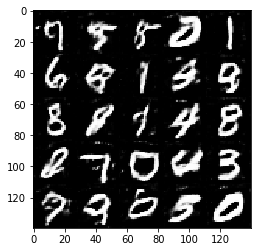

Epoch 2/2... Discriminator Loss: 1.6283... Generator Loss: 0.4259
Epoch 2/2... Discriminator Loss: 1.5091... Generator Loss: 0.4585
Epoch 2/2... Discriminator Loss: 1.7292... Generator Loss: 0.3948
Epoch 2/2... Discriminator Loss: 1.5742... Generator Loss: 0.4652
Epoch 2/2... Discriminator Loss: 1.5504... Generator Loss: 0.4166
Epoch 2/2... Discriminator Loss: 1.5462... Generator Loss: 0.6241
Epoch 2/2... Discriminator Loss: 1.5807... Generator Loss: 0.5194
Epoch 2/2... Discriminator Loss: 1.5266... Generator Loss: 1.2902
Epoch 2/2... Discriminator Loss: 1.9912... Generator Loss: 0.2944
Epoch 2/2... Discriminator Loss: 1.3879... Generator Loss: 0.6239
Epoch 2/2... Discriminator Loss: 1.7513... Generator Loss: 0.3924
Epoch 2/2... Discriminator Loss: 1.5864... Generator Loss: 0.4269
Epoch 2/2... Discriminator Loss: 1.3604... Generator Loss: 0.6421
Epoch 2/2... Discriminator Loss: 1.3069... Generator Loss: 0.7760
Epoch 2/2... Discriminator Loss: 1.5395... Generator Loss: 1.1735
Epoch 2/2.

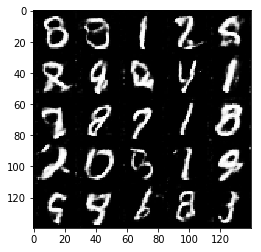

Epoch 2/2... Discriminator Loss: 1.3209... Generator Loss: 0.7091
Epoch 2/2... Discriminator Loss: 1.3993... Generator Loss: 0.5394
Epoch 2/2... Discriminator Loss: 1.7593... Generator Loss: 0.3528
Epoch 2/2... Discriminator Loss: 1.4541... Generator Loss: 0.6944
Epoch 2/2... Discriminator Loss: 1.8142... Generator Loss: 0.3682
Epoch 2/2... Discriminator Loss: 1.0728... Generator Loss: 1.1673
Epoch 2/2... Discriminator Loss: 1.7072... Generator Loss: 0.3456
Epoch 2/2... Discriminator Loss: 1.5711... Generator Loss: 0.5632
Epoch 2/2... Discriminator Loss: 1.4917... Generator Loss: 0.9765
Epoch 2/2... Discriminator Loss: 1.5517... Generator Loss: 0.5299
Epoch 2/2... Discriminator Loss: 1.4363... Generator Loss: 0.8406
Epoch 2/2... Discriminator Loss: 1.8483... Generator Loss: 0.3113
Epoch 2/2... Discriminator Loss: 1.8419... Generator Loss: 0.2685
Epoch 2/2... Discriminator Loss: 1.6400... Generator Loss: 0.4205
Epoch 2/2... Discriminator Loss: 1.5118... Generator Loss: 0.4020
Epoch 2/2.

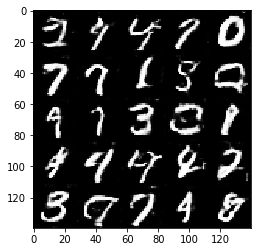

Epoch 2/2... Discriminator Loss: 1.2816... Generator Loss: 1.0095
Epoch 2/2... Discriminator Loss: 1.5290... Generator Loss: 0.5322
Epoch 2/2... Discriminator Loss: 1.5319... Generator Loss: 0.5345
Epoch 2/2... Discriminator Loss: 1.2834... Generator Loss: 0.8281
Epoch 2/2... Discriminator Loss: 1.7715... Generator Loss: 0.3833
Epoch 2/2... Discriminator Loss: 1.6138... Generator Loss: 0.3740
Epoch 2/2... Discriminator Loss: 1.5295... Generator Loss: 0.5345
Epoch 2/2... Discriminator Loss: 1.4372... Generator Loss: 0.5088
Epoch 2/2... Discriminator Loss: 1.5677... Generator Loss: 0.6570
Epoch 2/2... Discriminator Loss: 1.5268... Generator Loss: 0.6831
Epoch 2/2... Discriminator Loss: 1.5257... Generator Loss: 0.4251
Epoch 2/2... Discriminator Loss: 1.4861... Generator Loss: 0.5797
Epoch 2/2... Discriminator Loss: 1.5881... Generator Loss: 0.4509
Epoch 2/2... Discriminator Loss: 1.6105... Generator Loss: 0.4367
Epoch 2/2... Discriminator Loss: 1.3503... Generator Loss: 0.6145
Epoch 2/2.

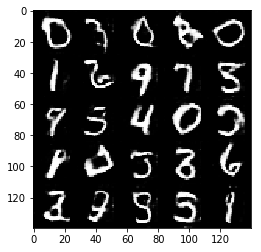

Epoch 2/2... Discriminator Loss: 1.4382... Generator Loss: 0.7520
Epoch 2/2... Discriminator Loss: 1.3309... Generator Loss: 1.0003
Epoch 2/2... Discriminator Loss: 1.9362... Generator Loss: 0.2667
Epoch 2/2... Discriminator Loss: 1.6085... Generator Loss: 0.5697
Epoch 2/2... Discriminator Loss: 1.3122... Generator Loss: 1.0620
Epoch 2/2... Discriminator Loss: 1.6726... Generator Loss: 0.4807
Epoch 2/2... Discriminator Loss: 1.5941... Generator Loss: 0.4482
Epoch 2/2... Discriminator Loss: 1.3974... Generator Loss: 0.9219
Epoch 2/2... Discriminator Loss: 1.3858... Generator Loss: 0.5208
Epoch 2/2... Discriminator Loss: 1.1761... Generator Loss: 0.9377
Epoch 2/2... Discriminator Loss: 1.5173... Generator Loss: 0.7303
Epoch 2/2... Discriminator Loss: 1.7424... Generator Loss: 1.1881
Epoch 2/2... Discriminator Loss: 1.6852... Generator Loss: 1.0245
Epoch 2/2... Discriminator Loss: 1.3638... Generator Loss: 1.0129
Epoch 2/2... Discriminator Loss: 1.5021... Generator Loss: 0.5689
Epoch 2/2.

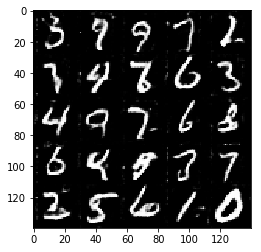

Epoch 2/2... Discriminator Loss: 1.3345... Generator Loss: 0.9433
Epoch 2/2... Discriminator Loss: 1.6131... Generator Loss: 0.4477
Epoch 2/2... Discriminator Loss: 1.5247... Generator Loss: 0.6814
Epoch 2/2... Discriminator Loss: 1.2555... Generator Loss: 1.0733
Epoch 2/2... Discriminator Loss: 1.4622... Generator Loss: 0.9264
Epoch 2/2... Discriminator Loss: 1.6164... Generator Loss: 0.5868
Epoch 2/2... Discriminator Loss: 1.5405... Generator Loss: 1.5922
Epoch 2/2... Discriminator Loss: 1.4911... Generator Loss: 0.9531
Epoch 2/2... Discriminator Loss: 1.5494... Generator Loss: 1.2837
Epoch 2/2... Discriminator Loss: 1.3433... Generator Loss: 0.7978
Epoch 2/2... Discriminator Loss: 1.3599... Generator Loss: 0.8796
Epoch 2/2... Discriminator Loss: 1.3661... Generator Loss: 0.6890
Epoch 2/2... Discriminator Loss: 1.5096... Generator Loss: 0.4196
Epoch 2/2... Discriminator Loss: 1.6000... Generator Loss: 0.4216
Epoch 2/2... Discriminator Loss: 1.3256... Generator Loss: 0.8233
Epoch 2/2.

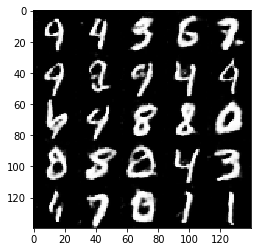

Epoch 2/2... Discriminator Loss: 1.3083... Generator Loss: 0.6733
Epoch 2/2... Discriminator Loss: 2.2464... Generator Loss: 0.9607
Epoch 2/2... Discriminator Loss: 1.5862... Generator Loss: 0.6295
Epoch 2/2... Discriminator Loss: 1.4353... Generator Loss: 0.9891
Epoch 2/2... Discriminator Loss: 1.2509... Generator Loss: 0.7809
Epoch 2/2... Discriminator Loss: 1.3950... Generator Loss: 0.7259
Epoch 2/2... Discriminator Loss: 1.5398... Generator Loss: 0.7277
Epoch 2/2... Discriminator Loss: 1.4454... Generator Loss: 0.6449
Epoch 2/2... Discriminator Loss: 1.5603... Generator Loss: 0.6800
Epoch 2/2... Discriminator Loss: 1.9711... Generator Loss: 0.2269
Epoch 2/2... Discriminator Loss: 1.3406... Generator Loss: 0.7412
Epoch 2/2... Discriminator Loss: 1.4744... Generator Loss: 0.6413
Epoch 2/2... Discriminator Loss: 1.3965... Generator Loss: 1.0957
Epoch 2/2... Discriminator Loss: 1.2593... Generator Loss: 0.7099
Epoch 2/2... Discriminator Loss: 1.4460... Generator Loss: 0.6027
Epoch 2/2.

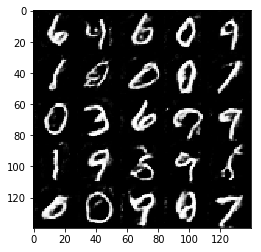

Epoch 2/2... Discriminator Loss: 1.5063... Generator Loss: 0.8112
Epoch 2/2... Discriminator Loss: 1.4451... Generator Loss: 0.5344
Epoch 2/2... Discriminator Loss: 1.4700... Generator Loss: 1.0217
Epoch 2/2... Discriminator Loss: 1.6849... Generator Loss: 0.3358
Epoch 2/2... Discriminator Loss: 1.4636... Generator Loss: 0.6315
Epoch 2/2... Discriminator Loss: 1.6961... Generator Loss: 0.4600
Epoch 2/2... Discriminator Loss: 1.3356... Generator Loss: 1.6192
Epoch 2/2... Discriminator Loss: 1.6576... Generator Loss: 0.4266
Epoch 2/2... Discriminator Loss: 1.6612... Generator Loss: 0.3539
Epoch 2/2... Discriminator Loss: 1.6835... Generator Loss: 0.5162
Epoch 2/2... Discriminator Loss: 1.6300... Generator Loss: 0.4969
Epoch 2/2... Discriminator Loss: 1.5243... Generator Loss: 0.5456
Epoch 2/2... Discriminator Loss: 1.3128... Generator Loss: 1.0338
Epoch 2/2... Discriminator Loss: 1.5078... Generator Loss: 0.4758
Epoch 2/2... Discriminator Loss: 1.9594... Generator Loss: 0.2819
Epoch 2/2.

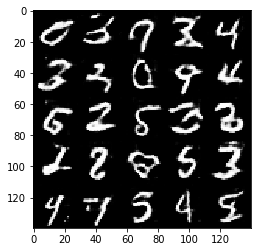

Epoch 2/2... Discriminator Loss: 1.4684... Generator Loss: 0.7397
Epoch 2/2... Discriminator Loss: 1.5000... Generator Loss: 0.4525
Epoch 2/2... Discriminator Loss: 1.1104... Generator Loss: 1.0065
Epoch 2/2... Discriminator Loss: 1.4665... Generator Loss: 0.4708
Epoch 2/2... Discriminator Loss: 1.8094... Generator Loss: 0.3915
Epoch 2/2... Discriminator Loss: 1.8996... Generator Loss: 0.2977
Epoch 2/2... Discriminator Loss: 1.7410... Generator Loss: 0.3047
Epoch 2/2... Discriminator Loss: 1.6525... Generator Loss: 1.0337
Epoch 2/2... Discriminator Loss: 1.4875... Generator Loss: 0.4922
Epoch 2/2... Discriminator Loss: 1.4097... Generator Loss: 1.1731
Epoch 2/2... Discriminator Loss: 1.4765... Generator Loss: 0.6269
Epoch 2/2... Discriminator Loss: 1.5123... Generator Loss: 0.4283
Epoch 2/2... Discriminator Loss: 1.3475... Generator Loss: 0.8712
Epoch 2/2... Discriminator Loss: 1.5157... Generator Loss: 0.7155
Epoch 2/2... Discriminator Loss: 1.3740... Generator Loss: 0.6752
Epoch 2/2.

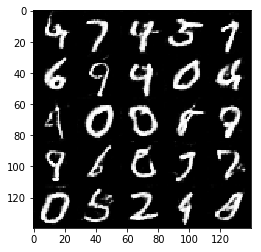

Epoch 2/2... Discriminator Loss: 1.7204... Generator Loss: 0.7126
Epoch 2/2... Discriminator Loss: 1.1825... Generator Loss: 1.2851
Epoch 2/2... Discriminator Loss: 1.4624... Generator Loss: 0.6471
Epoch 2/2... Discriminator Loss: 1.4123... Generator Loss: 0.9301
Epoch 2/2... Discriminator Loss: 1.6593... Generator Loss: 1.5655
Epoch 2/2... Discriminator Loss: 1.5507... Generator Loss: 0.4219
Epoch 2/2... Discriminator Loss: 1.6286... Generator Loss: 0.6095
Epoch 2/2... Discriminator Loss: 1.4627... Generator Loss: 0.4902
Epoch 2/2... Discriminator Loss: 1.8098... Generator Loss: 0.2985
Epoch 2/2... Discriminator Loss: 2.0184... Generator Loss: 0.2760
Epoch 2/2... Discriminator Loss: 1.6171... Generator Loss: 0.5653
Epoch 2/2... Discriminator Loss: 1.4890... Generator Loss: 0.7118
Epoch 2/2... Discriminator Loss: 1.4614... Generator Loss: 0.6573
Epoch 2/2... Discriminator Loss: 1.4396... Generator Loss: 1.2883
Epoch 2/2... Discriminator Loss: 1.4812... Generator Loss: 0.5879
Epoch 2/2.

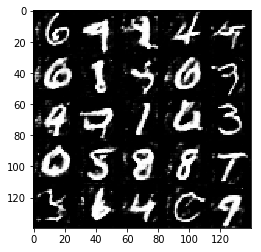

Epoch 2/2... Discriminator Loss: 1.4370... Generator Loss: 0.8546
Epoch 2/2... Discriminator Loss: 1.2657... Generator Loss: 1.0883
Epoch 2/2... Discriminator Loss: 1.5494... Generator Loss: 0.5098
Epoch 2/2... Discriminator Loss: 1.4886... Generator Loss: 0.8429
Epoch 2/2... Discriminator Loss: 1.4885... Generator Loss: 0.6240
Epoch 2/2... Discriminator Loss: 1.1981... Generator Loss: 0.6542
Epoch 2/2... Discriminator Loss: 1.4698... Generator Loss: 0.5716
Epoch 2/2... Discriminator Loss: 1.5806... Generator Loss: 0.8889
Epoch 2/2... Discriminator Loss: 1.4348... Generator Loss: 0.6994
Epoch 2/2... Discriminator Loss: 1.2454... Generator Loss: 0.6885
Epoch 2/2... Discriminator Loss: 1.6360... Generator Loss: 0.4330
Epoch 2/2... Discriminator Loss: 1.6482... Generator Loss: 1.5916
Epoch 2/2... Discriminator Loss: 1.2976... Generator Loss: 0.9244
Epoch 2/2... Discriminator Loss: 1.4425... Generator Loss: 0.6686
Epoch 2/2... Discriminator Loss: 1.4284... Generator Loss: 0.4844
Epoch 2/2.

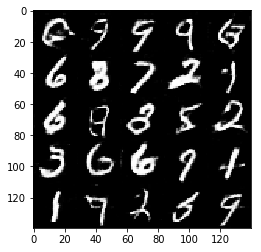

Epoch 2/2... Discriminator Loss: 1.3521... Generator Loss: 0.5361
Epoch 2/2... Discriminator Loss: 1.5916... Generator Loss: 0.7990
Epoch 2/2... Discriminator Loss: 1.6768... Generator Loss: 0.2802
Epoch 2/2... Discriminator Loss: 1.5029... Generator Loss: 0.5594
Epoch 2/2... Discriminator Loss: 1.5787... Generator Loss: 0.5623
Epoch 2/2... Discriminator Loss: 1.2703... Generator Loss: 0.9732
Epoch 2/2... Discriminator Loss: 1.5887... Generator Loss: 0.4192
Epoch 2/2... Discriminator Loss: 1.4516... Generator Loss: 0.6082
Epoch 2/2... Discriminator Loss: 1.5377... Generator Loss: 0.4488
Epoch 2/2... Discriminator Loss: 1.6281... Generator Loss: 0.6306
Epoch 2/2... Discriminator Loss: 1.3699... Generator Loss: 0.6587
Epoch 2/2... Discriminator Loss: 1.1436... Generator Loss: 0.6978
Epoch 2/2... Discriminator Loss: 1.4025... Generator Loss: 0.7181
Epoch 2/2... Discriminator Loss: 1.3167... Generator Loss: 0.9415
Epoch 2/2... Discriminator Loss: 1.4495... Generator Loss: 1.0914
Epoch 2/2.

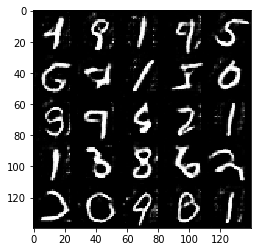

Epoch 2/2... Discriminator Loss: 1.3315... Generator Loss: 1.2113
Epoch 2/2... Discriminator Loss: 1.0712... Generator Loss: 0.6745
Epoch 2/2... Discriminator Loss: 1.4480... Generator Loss: 0.4809
Epoch 2/2... Discriminator Loss: 1.2096... Generator Loss: 0.6868
Epoch 2/2... Discriminator Loss: 1.6585... Generator Loss: 0.5279
Epoch 2/2... Discriminator Loss: 1.4593... Generator Loss: 0.7709
Epoch 2/2... Discriminator Loss: 1.2865... Generator Loss: 0.8051
Epoch 2/2... Discriminator Loss: 1.7107... Generator Loss: 0.5368
Epoch 2/2... Discriminator Loss: 1.3004... Generator Loss: 0.5947
Epoch 2/2... Discriminator Loss: 1.3533... Generator Loss: 0.7557
Epoch 2/2... Discriminator Loss: 1.1745... Generator Loss: 0.9398
Epoch 2/2... Discriminator Loss: 1.4244... Generator Loss: 0.4954
Epoch 2/2... Discriminator Loss: 1.5892... Generator Loss: 0.4357
Epoch 2/2... Discriminator Loss: 1.5914... Generator Loss: 0.4813
Epoch 2/2... Discriminator Loss: 1.8733... Generator Loss: 1.6975
Epoch 2/2.

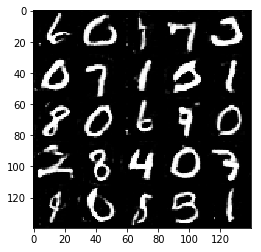

Epoch 2/2... Discriminator Loss: 1.8599... Generator Loss: 0.3202
Epoch 2/2... Discriminator Loss: 1.3643... Generator Loss: 0.8441
Epoch 2/2... Discriminator Loss: 1.4714... Generator Loss: 0.4570
Epoch 2/2... Discriminator Loss: 1.6938... Generator Loss: 0.6200
Epoch 2/2... Discriminator Loss: 1.6733... Generator Loss: 0.3069
Epoch 2/2... Discriminator Loss: 1.7392... Generator Loss: 0.3667
Epoch 2/2... Discriminator Loss: 1.6166... Generator Loss: 0.3687
Epoch 2/2... Discriminator Loss: 1.3964... Generator Loss: 0.8107
Epoch 2/2... Discriminator Loss: 1.3634... Generator Loss: 0.7298
Epoch 2/2... Discriminator Loss: 1.3206... Generator Loss: 0.5604
Epoch 2/2... Discriminator Loss: 1.5875... Generator Loss: 0.8739
Epoch 2/2... Discriminator Loss: 1.1474... Generator Loss: 1.0912
Epoch 2/2... Discriminator Loss: 1.1312... Generator Loss: 0.9484
Epoch 2/2... Discriminator Loss: 1.5177... Generator Loss: 0.5425
Epoch 2/2... Discriminator Loss: 1.5861... Generator Loss: 0.4741
Epoch 2/2.

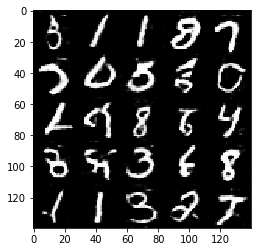

Epoch 2/2... Discriminator Loss: 1.5938... Generator Loss: 0.9150
Epoch 2/2... Discriminator Loss: 1.4273... Generator Loss: 0.5123
Epoch 2/2... Discriminator Loss: 1.2849... Generator Loss: 0.7302
Epoch 2/2... Discriminator Loss: 1.3582... Generator Loss: 0.5815
Epoch 2/2... Discriminator Loss: 1.7204... Generator Loss: 0.3289
Epoch 2/2... Discriminator Loss: 1.2322... Generator Loss: 0.9186
Epoch 2/2... Discriminator Loss: 1.2265... Generator Loss: 0.7541
Epoch 2/2... Discriminator Loss: 1.2269... Generator Loss: 1.4149
Epoch 2/2... Discriminator Loss: 1.6467... Generator Loss: 0.4536
Epoch 2/2... Discriminator Loss: 1.1824... Generator Loss: 0.7878
Epoch 2/2... Discriminator Loss: 1.8375... Generator Loss: 0.3347
Epoch 2/2... Discriminator Loss: 1.3096... Generator Loss: 0.7528
Epoch 2/2... Discriminator Loss: 1.4808... Generator Loss: 0.5690
Epoch 2/2... Discriminator Loss: 1.5394... Generator Loss: 0.5611
Epoch 2/2... Discriminator Loss: 1.4098... Generator Loss: 0.6651
Epoch 2/2.

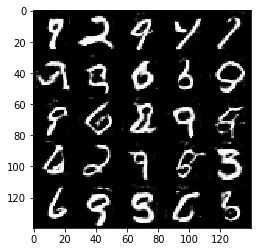

Epoch 2/2... Discriminator Loss: 1.5515... Generator Loss: 0.4293
Epoch 2/2... Discriminator Loss: 1.3048... Generator Loss: 0.6602
Epoch 2/2... Discriminator Loss: 1.2031... Generator Loss: 1.0030
Epoch 2/2... Discriminator Loss: 1.5551... Generator Loss: 0.5993
Epoch 2/2... Discriminator Loss: 1.3827... Generator Loss: 0.6082
Epoch 2/2... Discriminator Loss: 1.5612... Generator Loss: 0.4925
Epoch 2/2... Discriminator Loss: 1.3098... Generator Loss: 0.8031
Epoch 2/2... Discriminator Loss: 1.4232... Generator Loss: 0.5256
Epoch 2/2... Discriminator Loss: 1.3303... Generator Loss: 0.6032
Epoch 2/2... Discriminator Loss: 1.6584... Generator Loss: 0.4394
Epoch 2/2... Discriminator Loss: 1.4690... Generator Loss: 0.7500
Epoch 2/2... Discriminator Loss: 1.4741... Generator Loss: 0.7823
Epoch 2/2... Discriminator Loss: 1.4441... Generator Loss: 0.6248
Epoch 2/2... Discriminator Loss: 1.6291... Generator Loss: 0.4642
Epoch 2/2... Discriminator Loss: 1.6005... Generator Loss: 0.4874
Epoch 2/2.

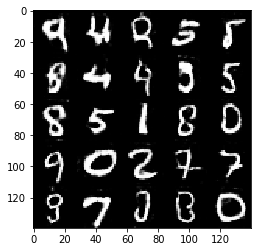

Epoch 2/2... Discriminator Loss: 1.2250... Generator Loss: 0.5420
Epoch 2/2... Discriminator Loss: 1.2357... Generator Loss: 0.8366
Epoch 2/2... Discriminator Loss: 1.1003... Generator Loss: 1.0491
Epoch 2/2... Discriminator Loss: 1.3292... Generator Loss: 0.7631
Epoch 2/2... Discriminator Loss: 0.9821... Generator Loss: 1.2785
Epoch 2/2... Discriminator Loss: 1.4718... Generator Loss: 0.7388
Epoch 2/2... Discriminator Loss: 1.2126... Generator Loss: 0.9665
Epoch 2/2... Discriminator Loss: 0.9912... Generator Loss: 1.3403
Epoch 2/2... Discriminator Loss: 1.4256... Generator Loss: 0.6169
Epoch 2/2... Discriminator Loss: 1.6010... Generator Loss: 0.5173
Epoch 2/2... Discriminator Loss: 1.0674... Generator Loss: 0.7717
Epoch 2/2... Discriminator Loss: 1.3451... Generator Loss: 0.5231
Epoch 2/2... Discriminator Loss: 1.2864... Generator Loss: 0.8629
Epoch 2/2... Discriminator Loss: 1.3167... Generator Loss: 0.8517
Epoch 2/2... Discriminator Loss: 1.3430... Generator Loss: 0.6662
Epoch 2/2.

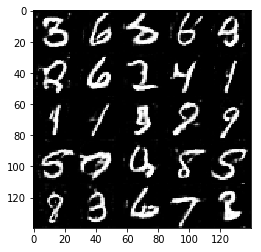

Epoch 2/2... Discriminator Loss: 1.5173... Generator Loss: 0.7158
Epoch 2/2... Discriminator Loss: 1.1551... Generator Loss: 0.8966
Epoch 2/2... Discriminator Loss: 1.3241... Generator Loss: 0.7101
Epoch 2/2... Discriminator Loss: 1.2065... Generator Loss: 1.3480
Epoch 2/2... Discriminator Loss: 1.3825... Generator Loss: 0.5021
Epoch 2/2... Discriminator Loss: 1.4246... Generator Loss: 0.3863
Epoch 2/2... Discriminator Loss: 1.4897... Generator Loss: 0.4717
Epoch 2/2... Discriminator Loss: 1.3816... Generator Loss: 0.4405
Epoch 2/2... Discriminator Loss: 1.6236... Generator Loss: 0.7948
Epoch 2/2... Discriminator Loss: 1.2896... Generator Loss: 0.8003
Epoch 2/2... Discriminator Loss: 1.3524... Generator Loss: 0.7861
Epoch 2/2... Discriminator Loss: 1.8347... Generator Loss: 0.3980
Epoch 2/2... Discriminator Loss: 1.4664... Generator Loss: 1.5306
Epoch 2/2... Discriminator Loss: 1.4263... Generator Loss: 0.5841
Epoch 2/2... Discriminator Loss: 1.3688... Generator Loss: 0.7071
Epoch 2/2.

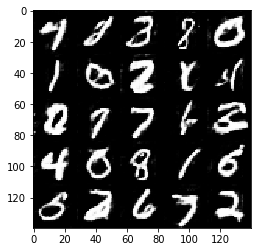

Epoch 2/2... Discriminator Loss: 1.6507... Generator Loss: 0.8862
Epoch 2/2... Discriminator Loss: 1.2213... Generator Loss: 1.3203
Epoch 2/2... Discriminator Loss: 1.4607... Generator Loss: 0.7948
Epoch 2/2... Discriminator Loss: 1.7523... Generator Loss: 0.6305
Epoch 2/2... Discriminator Loss: 1.5385... Generator Loss: 0.7602
Epoch 2/2... Discriminator Loss: 1.1820... Generator Loss: 1.2041
Epoch 2/2... Discriminator Loss: 1.3498... Generator Loss: 0.5272
Epoch 2/2... Discriminator Loss: 1.4853... Generator Loss: 0.4475
Epoch 2/2... Discriminator Loss: 1.2506... Generator Loss: 0.6630
Epoch 2/2... Discriminator Loss: 1.1561... Generator Loss: 0.9019


In [ ]:
batch_size = 32
z_dim = 200
learning_rate = 0.0005
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.5399... Generator Loss: 0.1797
Epoch 1/1... Discriminator Loss: 2.3942... Generator Loss: 0.1825
Epoch 1/1... Discriminator Loss: 3.2390... Generator Loss: 0.0678
Epoch 1/1... Discriminator Loss: 3.5831... Generator Loss: 0.1750
Epoch 1/1... Discriminator Loss: 2.8277... Generator Loss: 0.1446
Epoch 1/1... Discriminator Loss: 1.6352... Generator Loss: 0.4696
Epoch 1/1... Discriminator Loss: 2.2192... Generator Loss: 0.4658
Epoch 1/1... Discriminator Loss: 1.5218... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 1.7444... Generator Loss: 1.0298
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.9322
Epoch 1/1... Discriminator Loss: 1.8771... Generator Loss: 0.4586
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 0.9168
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.6068
Epoch 1/1... Discriminator Loss: 1.5911... Generator Loss: 0.5179
Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.8746
Epoch 1/1.

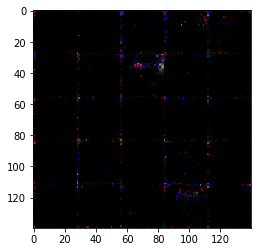

Epoch 1/1... Discriminator Loss: 1.6643... Generator Loss: 0.6272
Epoch 1/1... Discriminator Loss: 1.6606... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 2.0021... Generator Loss: 0.2751
Epoch 1/1... Discriminator Loss: 1.4848... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.9132... Generator Loss: 0.5140
Epoch 1/1... Discriminator Loss: 1.8215... Generator Loss: 0.4406
Epoch 1/1... Discriminator Loss: 2.1024... Generator Loss: 0.1639
Epoch 1/1... Discriminator Loss: 2.0592... Generator Loss: 0.3135
Epoch 1/1... Discriminator Loss: 1.5888... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 2.0032... Generator Loss: 0.4635
Epoch 1/1... Discriminator Loss: 1.7426... Generator Loss: 0.5936
Epoch 1/1... Discriminator Loss: 1.8021... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 2.2118... Generator Loss: 0.2676
Epoch 1/1... Discriminator Loss: 1.8668... Generator Loss: 0.4359
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.5364
Epoch 1/1.

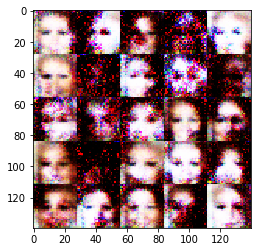

Epoch 1/1... Discriminator Loss: 2.1955... Generator Loss: 0.2943
Epoch 1/1... Discriminator Loss: 2.5323... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 2.2850... Generator Loss: 0.3382
Epoch 1/1... Discriminator Loss: 1.8929... Generator Loss: 0.3127
Epoch 1/1... Discriminator Loss: 1.7891... Generator Loss: 0.5801
Epoch 1/1... Discriminator Loss: 2.1776... Generator Loss: 0.2909
Epoch 1/1... Discriminator Loss: 1.9054... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 2.1791... Generator Loss: 0.4051
Epoch 1/1... Discriminator Loss: 2.9393... Generator Loss: 0.1330
Epoch 1/1... Discriminator Loss: 1.9912... Generator Loss: 0.2919
Epoch 1/1... Discriminator Loss: 2.0034... Generator Loss: 0.5447
Epoch 1/1... Discriminator Loss: 1.7403... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 2.7892... Generator Loss: 0.2201
Epoch 1/1... Discriminator Loss: 2.2079... Generator Loss: 0.2191
Epoch 1/1... Discriminator Loss: 2.1940... Generator Loss: 0.4801
Epoch 1/1.

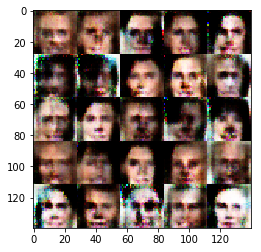

Epoch 1/1... Discriminator Loss: 1.6210... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 2.0495... Generator Loss: 0.2304
Epoch 1/1... Discriminator Loss: 2.4338... Generator Loss: 0.3318
Epoch 1/1... Discriminator Loss: 2.5790... Generator Loss: 0.5191
Epoch 1/1... Discriminator Loss: 1.9595... Generator Loss: 0.3361
Epoch 1/1... Discriminator Loss: 2.4835... Generator Loss: 0.2435
Epoch 1/1... Discriminator Loss: 1.9461... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 2.1356... Generator Loss: 0.3510
Epoch 1/1... Discriminator Loss: 2.3497... Generator Loss: 0.4091
Epoch 1/1... Discriminator Loss: 2.0981... Generator Loss: 0.5630
Epoch 1/1... Discriminator Loss: 2.4377... Generator Loss: 0.2754
Epoch 1/1... Discriminator Loss: 2.2825... Generator Loss: 0.3597
Epoch 1/1... Discriminator Loss: 2.3384... Generator Loss: 0.2741
Epoch 1/1... Discriminator Loss: 2.1652... Generator Loss: 0.3094
Epoch 1/1... Discriminator Loss: 2.3606... Generator Loss: 0.3166
Epoch 1/1.

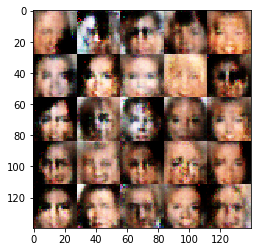

Epoch 1/1... Discriminator Loss: 2.0554... Generator Loss: 0.3962
Epoch 1/1... Discriminator Loss: 2.0813... Generator Loss: 0.3024
Epoch 1/1... Discriminator Loss: 2.0378... Generator Loss: 0.3465
Epoch 1/1... Discriminator Loss: 2.0928... Generator Loss: 0.3328
Epoch 1/1... Discriminator Loss: 1.8160... Generator Loss: 0.3813
Epoch 1/1... Discriminator Loss: 2.2635... Generator Loss: 0.2538
Epoch 1/1... Discriminator Loss: 2.1647... Generator Loss: 0.3252
Epoch 1/1... Discriminator Loss: 1.9440... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 1.8042... Generator Loss: 0.4685
Epoch 1/1... Discriminator Loss: 1.9053... Generator Loss: 0.4060
Epoch 1/1... Discriminator Loss: 1.9342... Generator Loss: 0.2866
Epoch 1/1... Discriminator Loss: 2.0724... Generator Loss: 0.3504
Epoch 1/1... Discriminator Loss: 1.8053... Generator Loss: 0.4697
Epoch 1/1... Discriminator Loss: 2.1119... Generator Loss: 0.4221
Epoch 1/1... Discriminator Loss: 2.1044... Generator Loss: 0.2949
Epoch 1/1.

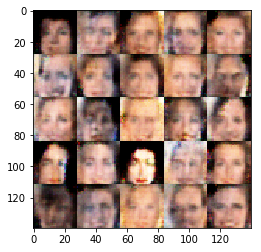

Epoch 1/1... Discriminator Loss: 1.8105... Generator Loss: 0.3292
Epoch 1/1... Discriminator Loss: 2.0621... Generator Loss: 0.3778
Epoch 1/1... Discriminator Loss: 2.1483... Generator Loss: 0.3587
Epoch 1/1... Discriminator Loss: 2.1539... Generator Loss: 0.2671
Epoch 1/1... Discriminator Loss: 2.0018... Generator Loss: 0.3046
Epoch 1/1... Discriminator Loss: 2.1608... Generator Loss: 0.2811
Epoch 1/1... Discriminator Loss: 2.0334... Generator Loss: 0.3857
Epoch 1/1... Discriminator Loss: 1.9492... Generator Loss: 0.4921
Epoch 1/1... Discriminator Loss: 1.9913... Generator Loss: 0.4015
Epoch 1/1... Discriminator Loss: 2.0323... Generator Loss: 0.3944
Epoch 1/1... Discriminator Loss: 2.0814... Generator Loss: 0.2853
Epoch 1/1... Discriminator Loss: 2.0926... Generator Loss: 0.3703
Epoch 1/1... Discriminator Loss: 1.9971... Generator Loss: 0.4660
Epoch 1/1... Discriminator Loss: 2.2216... Generator Loss: 0.3201
Epoch 1/1... Discriminator Loss: 2.1500... Generator Loss: 0.3586
Epoch 1/1.

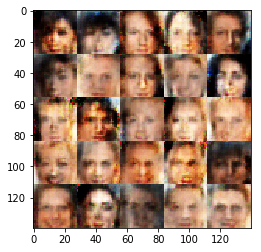

Epoch 1/1... Discriminator Loss: 2.1121... Generator Loss: 0.2959
Epoch 1/1... Discriminator Loss: 1.8835... Generator Loss: 0.4795
Epoch 1/1... Discriminator Loss: 1.8491... Generator Loss: 0.3555
Epoch 1/1... Discriminator Loss: 1.9982... Generator Loss: 0.4069
Epoch 1/1... Discriminator Loss: 1.9811... Generator Loss: 0.3955
Epoch 1/1... Discriminator Loss: 1.7758... Generator Loss: 0.4986
Epoch 1/1... Discriminator Loss: 2.0519... Generator Loss: 0.3974
Epoch 1/1... Discriminator Loss: 2.0098... Generator Loss: 0.3259
Epoch 1/1... Discriminator Loss: 1.7527... Generator Loss: 0.4338
Epoch 1/1... Discriminator Loss: 1.9163... Generator Loss: 0.3945
Epoch 1/1... Discriminator Loss: 1.9032... Generator Loss: 0.4131
Epoch 1/1... Discriminator Loss: 2.2168... Generator Loss: 0.2605
Epoch 1/1... Discriminator Loss: 1.6859... Generator Loss: 0.5072
Epoch 1/1... Discriminator Loss: 1.7924... Generator Loss: 0.4884
Epoch 1/1... Discriminator Loss: 2.0743... Generator Loss: 0.3475
Epoch 1/1.

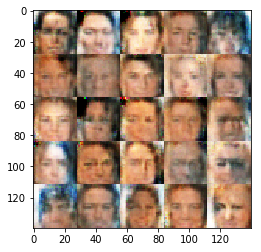

Epoch 1/1... Discriminator Loss: 1.7903... Generator Loss: 0.5357
Epoch 1/1... Discriminator Loss: 2.1105... Generator Loss: 0.3183
Epoch 1/1... Discriminator Loss: 1.7349... Generator Loss: 0.3680
Epoch 1/1... Discriminator Loss: 1.7771... Generator Loss: 0.6102
Epoch 1/1... Discriminator Loss: 1.8648... Generator Loss: 0.4207
Epoch 1/1... Discriminator Loss: 1.7116... Generator Loss: 0.4029
Epoch 1/1... Discriminator Loss: 1.7510... Generator Loss: 0.5408
Epoch 1/1... Discriminator Loss: 1.7084... Generator Loss: 0.4816
Epoch 1/1... Discriminator Loss: 1.7287... Generator Loss: 0.4745
Epoch 1/1... Discriminator Loss: 1.9533... Generator Loss: 0.4367
Epoch 1/1... Discriminator Loss: 1.7689... Generator Loss: 0.4728
Epoch 1/1... Discriminator Loss: 1.7703... Generator Loss: 0.4381
Epoch 1/1... Discriminator Loss: 1.8238... Generator Loss: 0.4780
Epoch 1/1... Discriminator Loss: 1.7761... Generator Loss: 0.4376
Epoch 1/1... Discriminator Loss: 1.7221... Generator Loss: 0.5397
Epoch 1/1.

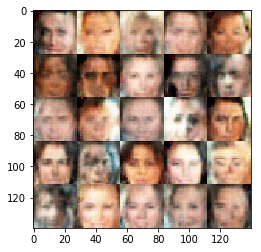

Epoch 1/1... Discriminator Loss: 1.7913... Generator Loss: 0.4031
Epoch 1/1... Discriminator Loss: 1.9763... Generator Loss: 0.4674
Epoch 1/1... Discriminator Loss: 1.9246... Generator Loss: 0.4375
Epoch 1/1... Discriminator Loss: 1.7517... Generator Loss: 0.3995
Epoch 1/1... Discriminator Loss: 1.8158... Generator Loss: 0.5762
Epoch 1/1... Discriminator Loss: 1.8260... Generator Loss: 0.4453
Epoch 1/1... Discriminator Loss: 1.8366... Generator Loss: 0.4440
Epoch 1/1... Discriminator Loss: 1.8292... Generator Loss: 0.4937
Epoch 1/1... Discriminator Loss: 1.7977... Generator Loss: 0.4343
Epoch 1/1... Discriminator Loss: 1.7895... Generator Loss: 0.5274
Epoch 1/1... Discriminator Loss: 1.6184... Generator Loss: 0.5087
Epoch 1/1... Discriminator Loss: 1.8061... Generator Loss: 0.5042
Epoch 1/1... Discriminator Loss: 1.8056... Generator Loss: 0.3654
Epoch 1/1... Discriminator Loss: 1.9857... Generator Loss: 0.3519
Epoch 1/1... Discriminator Loss: 1.8993... Generator Loss: 0.4544
Epoch 1/1.

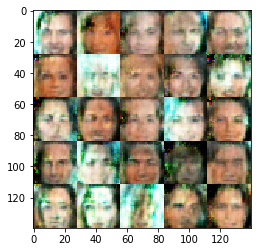

Epoch 1/1... Discriminator Loss: 1.8605... Generator Loss: 0.5694
Epoch 1/1... Discriminator Loss: 1.8202... Generator Loss: 0.4408
Epoch 1/1... Discriminator Loss: 1.9033... Generator Loss: 0.5239
Epoch 1/1... Discriminator Loss: 1.6069... Generator Loss: 0.4805
Epoch 1/1... Discriminator Loss: 1.8537... Generator Loss: 0.3743
Epoch 1/1... Discriminator Loss: 1.8430... Generator Loss: 0.5158
Epoch 1/1... Discriminator Loss: 1.7614... Generator Loss: 0.5032
Epoch 1/1... Discriminator Loss: 1.7605... Generator Loss: 0.4742
Epoch 1/1... Discriminator Loss: 1.7647... Generator Loss: 0.4424
Epoch 1/1... Discriminator Loss: 1.6743... Generator Loss: 0.4965
Epoch 1/1... Discriminator Loss: 1.5988... Generator Loss: 0.5964
Epoch 1/1... Discriminator Loss: 1.9358... Generator Loss: 0.4752
Epoch 1/1... Discriminator Loss: 1.6391... Generator Loss: 0.4277
Epoch 1/1... Discriminator Loss: 1.7031... Generator Loss: 0.4718
Epoch 1/1... Discriminator Loss: 1.6068... Generator Loss: 0.5101
Epoch 1/1.

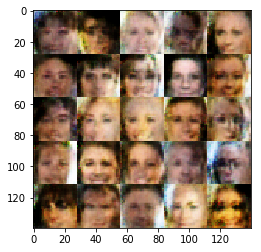

Epoch 1/1... Discriminator Loss: 1.8809... Generator Loss: 0.4498
Epoch 1/1... Discriminator Loss: 1.8035... Generator Loss: 0.4785
Epoch 1/1... Discriminator Loss: 1.9177... Generator Loss: 0.3473
Epoch 1/1... Discriminator Loss: 1.8021... Generator Loss: 0.5198
Epoch 1/1... Discriminator Loss: 1.8525... Generator Loss: 0.4855
Epoch 1/1... Discriminator Loss: 1.7328... Generator Loss: 0.4790
Epoch 1/1... Discriminator Loss: 1.6166... Generator Loss: 0.5297
Epoch 1/1... Discriminator Loss: 1.6978... Generator Loss: 0.5534
Epoch 1/1... Discriminator Loss: 1.9721... Generator Loss: 0.3812
Epoch 1/1... Discriminator Loss: 1.8311... Generator Loss: 0.5326
Epoch 1/1... Discriminator Loss: 1.7092... Generator Loss: 0.5824
Epoch 1/1... Discriminator Loss: 1.7065... Generator Loss: 0.6286
Epoch 1/1... Discriminator Loss: 1.7349... Generator Loss: 0.5595
Epoch 1/1... Discriminator Loss: 1.6839... Generator Loss: 0.6064
Epoch 1/1... Discriminator Loss: 1.7922... Generator Loss: 0.5062
Epoch 1/1.

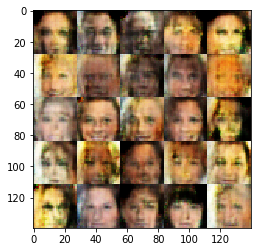

Epoch 1/1... Discriminator Loss: 1.7856... Generator Loss: 0.4680
Epoch 1/1... Discriminator Loss: 1.6693... Generator Loss: 0.5664
Epoch 1/1... Discriminator Loss: 1.6923... Generator Loss: 0.5399
Epoch 1/1... Discriminator Loss: 1.8341... Generator Loss: 0.4439
Epoch 1/1... Discriminator Loss: 1.7477... Generator Loss: 0.4552
Epoch 1/1... Discriminator Loss: 1.7371... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 1.7176... Generator Loss: 0.4281
Epoch 1/1... Discriminator Loss: 1.9590... Generator Loss: 0.3759
Epoch 1/1... Discriminator Loss: 1.9614... Generator Loss: 0.3811
Epoch 1/1... Discriminator Loss: 1.7982... Generator Loss: 0.4956
Epoch 1/1... Discriminator Loss: 1.7440... Generator Loss: 0.4702
Epoch 1/1... Discriminator Loss: 1.7239... Generator Loss: 0.5123
Epoch 1/1... Discriminator Loss: 1.7295... Generator Loss: 0.4793
Epoch 1/1... Discriminator Loss: 1.5838... Generator Loss: 0.5110
Epoch 1/1... Discriminator Loss: 1.6755... Generator Loss: 0.4523
Epoch 1/1.

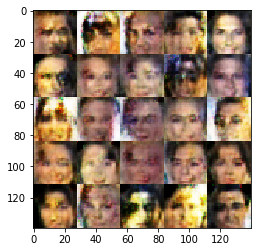

Epoch 1/1... Discriminator Loss: 1.7017... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 1.8855... Generator Loss: 0.4794
Epoch 1/1... Discriminator Loss: 1.6209... Generator Loss: 0.5914
Epoch 1/1... Discriminator Loss: 1.5814... Generator Loss: 0.5825
Epoch 1/1... Discriminator Loss: 1.7329... Generator Loss: 0.4916
Epoch 1/1... Discriminator Loss: 1.6811... Generator Loss: 0.5179
Epoch 1/1... Discriminator Loss: 1.8194... Generator Loss: 0.4649
Epoch 1/1... Discriminator Loss: 1.7756... Generator Loss: 0.5017
Epoch 1/1... Discriminator Loss: 1.7515... Generator Loss: 0.5424
Epoch 1/1... Discriminator Loss: 1.8656... Generator Loss: 0.5466
Epoch 1/1... Discriminator Loss: 1.9210... Generator Loss: 0.4205
Epoch 1/1... Discriminator Loss: 1.6456... Generator Loss: 0.5989
Epoch 1/1... Discriminator Loss: 1.7969... Generator Loss: 0.4529
Epoch 1/1... Discriminator Loss: 1.7991... Generator Loss: 0.5143
Epoch 1/1... Discriminator Loss: 1.7256... Generator Loss: 0.6458
Epoch 1/1.

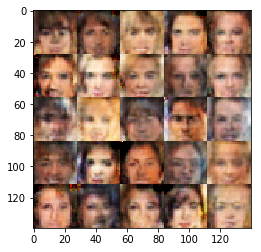

Epoch 1/1... Discriminator Loss: 1.7591... Generator Loss: 0.4886
Epoch 1/1... Discriminator Loss: 1.8265... Generator Loss: 0.4728
Epoch 1/1... Discriminator Loss: 1.8147... Generator Loss: 0.4792
Epoch 1/1... Discriminator Loss: 1.6500... Generator Loss: 0.5039
Epoch 1/1... Discriminator Loss: 1.7165... Generator Loss: 0.5651
Epoch 1/1... Discriminator Loss: 1.6217... Generator Loss: 0.5101
Epoch 1/1... Discriminator Loss: 1.9014... Generator Loss: 0.4503
Epoch 1/1... Discriminator Loss: 1.7573... Generator Loss: 0.5742
Epoch 1/1... Discriminator Loss: 1.7375... Generator Loss: 0.4556
Epoch 1/1... Discriminator Loss: 1.7783... Generator Loss: 0.4595
Epoch 1/1... Discriminator Loss: 1.6329... Generator Loss: 0.5236
Epoch 1/1... Discriminator Loss: 1.7227... Generator Loss: 0.5820
Epoch 1/1... Discriminator Loss: 1.7187... Generator Loss: 0.5739
Epoch 1/1... Discriminator Loss: 1.7144... Generator Loss: 0.5259
Epoch 1/1... Discriminator Loss: 1.6872... Generator Loss: 0.4943
Epoch 1/1.

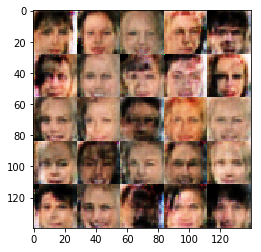

Epoch 1/1... Discriminator Loss: 1.5800... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 1.7101... Generator Loss: 0.5387


In [ ]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.